In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

from data_loader import Alc_Dataset
from TripletNet import TripletNet

## Get dataset embeddings

In [2]:
def get_dataset_preds(img_dir, model_dir):
    model = TripletNet()
    model.load_state_dict(torch.load(model_dir))
    model.eval()

    dataset = Alc_Dataset(
        img_dir=img_dir,
        img_size=224,
        eval=True
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=True
    )
    
    res = []
    for img, cat, cls, img_path in dataloader:
        pred = model(img)[0].detach().numpy()
        res.append((img_path[0], pred, cat[0].item(), cls[0].item()))
        
    return res, dataset.img_cat_keys, dataset.img_class_keys

In [3]:
model_dir = 'saved_models/no_ref_hierc_v1.pt'
train_img_dir = 'alc_data/train'
val_img_dir = 'alc_data/test'

train_dataset_res, train_cat_keys, train_cls_keys = get_dataset_preds(train_img_dir, model_dir)
val_dataset_res, val_cat_keys, val_cls_keys = get_dataset_preds(val_img_dir, model_dir)

assert train_cat_keys==val_cat_keys and train_cls_keys==val_cls_keys

In [28]:
train_paths = [x[0] for x in train_dataset_res]
train_embeddings = [x[1] for x in train_dataset_res]
train_cats = [x[2] for x in train_dataset_res]
train_clss = [x[3] for x in train_dataset_res]

val_paths = [x[0] for x in val_dataset_res]
val_embeddings = [x[1] for x in val_dataset_res]
val_cats = [x[2] for x in val_dataset_res]
val_clss = [x[3] for x in val_dataset_res]

## KNN

In [36]:
def fit_knn(embs, labels):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(embs, labels)
    return knn

def get_pred_acc(knn, embs, labels):
    preds = knn.predict(embs)
    num_correct = 0
    for i in range(len(embs)):
        if labels[i]==preds[i]:
            num_correct += 1
            
    return num_correct / len(embs)

In [37]:
cat_knn = fit_knn(train_embeddings, train_cats)
cls_knn = fit_knn(train_embeddings, train_clss)

val_cat_acc = get_pred_acc(cat_knn, val_embeddings, val_cats)
val_cls_acc = get_pred_acc(cls_knn, val_embeddings, val_clss)

print("Category acc: {} - Class acc: {}".format(val_cat_acc, val_cls_acc))

Category acc: 0.9905660377358491 - Class acc: 0.8962264150943396


In [54]:
def get_topN_paths(knn, val_idx, val_dataset_res, train_paths, N=5):
    val_paths = [x[0] for x in val_dataset_res]
    val_embeddings = [x[1] for x in val_dataset_res]
    val_cats = [x[2] for x in val_dataset_res]
    val_clss = [x[3] for x in val_dataset_res]
    
    _, topN_idxs = knn.kneighbors(val_embeddings[val_idx].reshape(1, -1), n_neighbors=N)
    topN_paths = np.array(train_paths)[topN_idxs[0]]
    
    return val_paths[val_idx], topN_paths

In [70]:
def plot_top_sims(anc_path, topN_paths, N=5):
    plt_idx = 1

    plt.figure(figsize=(20,20))
    for i in range(N+1):
        if i==0:
            img = np.array(Image.open(anc_path).convert("RGB"))
            plt.subplot(1,N+1,plt_idx)
            plt.imshow(img)
            plt.title("Anchor")
            plt_idx += 1

        else:
            img = np.array(Image.open(topN_paths[i-1]).convert("RGB"))
            plt.subplot(1,N+1,plt_idx)
            plt.imshow(img)
            plt.title("{} sim".format(plt_idx-1))
            plt_idx += 1


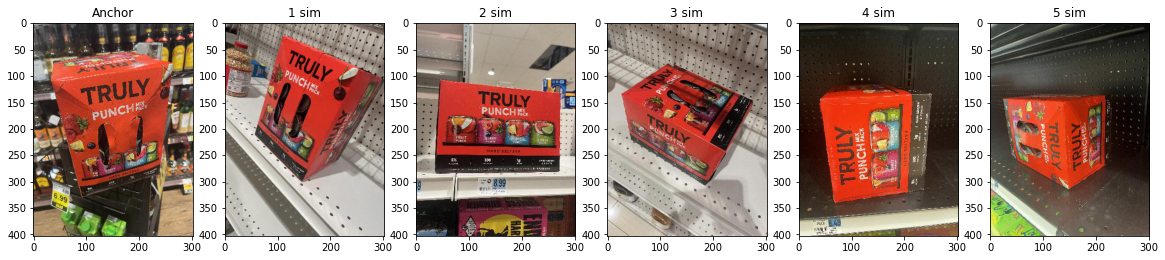

In [72]:
idx = 0

anc_path, topN_paths = get_topN_paths(cls_knn, idx, val_dataset_res, train_paths, N)
plot_top_sims(anc_path, topN_paths, N=5)

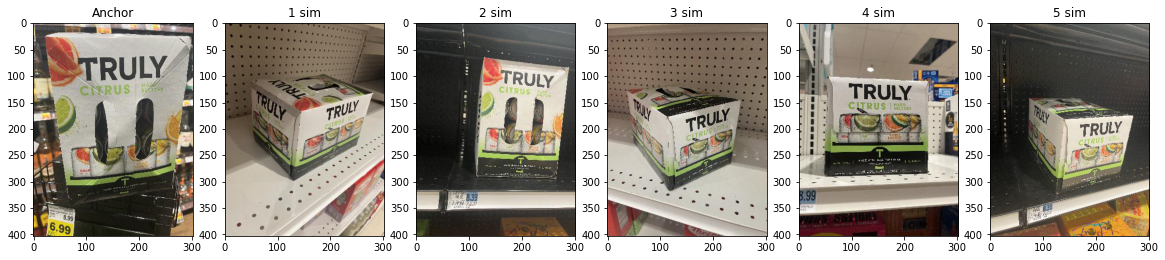

In [73]:
idx = 1

anc_path, topN_paths = get_topN_paths(cls_knn, idx, val_dataset_res, train_paths, N)
plot_top_sims(anc_path, topN_paths, N=5)

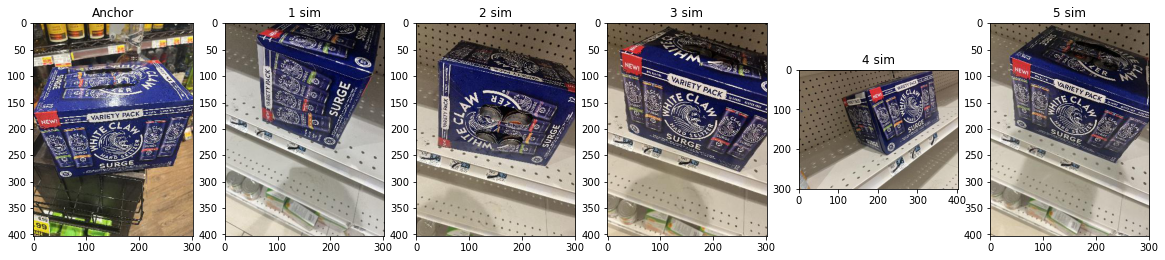

In [75]:
idx = 10

anc_path, topN_paths = get_topN_paths(cls_knn, idx, val_dataset_res, train_paths, N)
plot_top_sims(anc_path, topN_paths, N=5)

## TSNE (visualization)

In [6]:
dataset_res = val_dataset_res

result_df = None
for row in dataset_res:
    pred = row[1]
    cat = row[2]
    cls = row[3]
    if result_df is None:
        cols = list(range(len(pred)))
        cols.append('cat')
        cols.append('cls')
        result_df = pd.DataFrame(columns=cols)
    cur_row = list(pred) 
    cur_row.append(cat)
    cur_row.append(cls)
    result_df.loc[len(result_df)] = cur_row
    

In [7]:
cat_tsne = TSNE()
cat_x_2d_embs = cat_tsne.fit_transform(result_df.drop(['cat'], axis=1).drop(['cls'], axis=1))
cat_emb_labels = result_df['cat'].values

cls_tsne = TSNE()
cls_x_2d_embs = cls_tsne.fit_transform(result_df.drop(['cat'], axis=1).drop(['cls'], axis=1))
cls_emb_labels = result_df['cls'].values

/home/ekim/anaconda3/envs/zData/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ekim/anaconda3/envs/zData/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ekim/anaconda3/envs/zData/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ekim/anaconda3/envs/zData/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

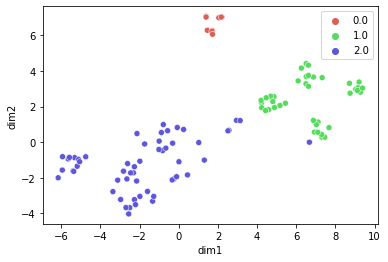

In [8]:
cat_df = pd.DataFrame()
cat_df['y'] = cat_emb_labels
cat_df['dim1'] = cat_x_2d_embs[:,0]
cat_df['dim2'] = cat_x_2d_embs[:,1]

sns.scatterplot(x="dim1", y="dim2", hue=cat_df.y.tolist(),
                palette=sns.color_palette("hls", len(np.unique(cat_df.y.tolist()))),
                data=cat_df)

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

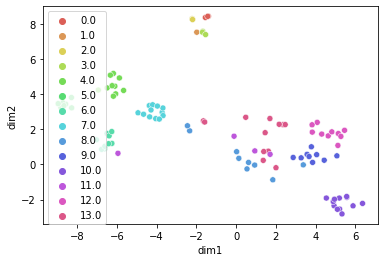

In [9]:
cls_df = pd.DataFrame()
cls_df['y'] = cls_emb_labels
cls_df['dim1'] = cls_x_2d_embs[:,0]
cls_df['dim2'] = cls_x_2d_embs[:,1]

sns.scatterplot(x="dim1", y="dim2", hue=cls_df.y.tolist(),
                palette=sns.color_palette("hls", len(np.unique(cls_df.y.tolist()))),
                data=cls_df)